<a href="https://colab.research.google.com/github/amrmoohamed/RLinTrading/blob/main/Single_Instrument_APPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Article**
https://levelup.gitconnected.com/using-tensortrade-for-making-a-simple-trading-algorithm-6fad4d9bc79c



#**installation**

In [ ]:
!#!cp -r /content/tensortrade /usr/local/lib/python3.7/dist-packages

#insatalling Tensortrade module
!pip install git+https://github.com/tensortrade-org/tensortrade.git
!pip install -r /content/tensortrade/requirements.txt
#installing some modules
!pip install ccxt
!pip install ray
!pip install symfit
!pip install tensorboardX

In [ ]:
!pip install yahoo_fin
!pip install yfinance

**Remember to restart runtime after installing!!**

#**Importing**

In [ ]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import ray.rllib.agents.ppo as ppo
import tensortrade.env.default as default
from gym.spaces import Discrete
from ray import tune
from ray.tune.registry import register_env
from symfit import parameters, variables, sin, cos, Fit
from tensortrade.env.default.actions import TensorTradeActionScheme
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.env.generic import Renderer
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.instruments import Instrument
from tensortrade.oms.orders import proportion_order
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio

In [ ]:
from pandas_datareader import data as pdr
from yahoo_fin import stock_info as si
from yahoo_fin.stock_info import get_data
from pandas import ExcelWriter
import yfinance as yf
import pandas as pd
import datetime
import time
yf.pdr_override()

#**Retreive Data**

In [ ]:
yeartoday = 365
years = 7
start_date = datetime.datetime.now() - datetime.timedelta(days= years*yeartoday)

end_date = datetime.date.today()

In [ ]:
df = get_data('AAPL',start_date,end_date,index_as_date = True, interval="1d")
df.to_csv('AAPL.csv')

In [ ]:
data = pd.read_csv('/content/AAPL.csv', index_col=0)
data.head(2)

,open,high,low,close,adjclose,volume,ticker
2014-06-05,23.078571,23.191786,22.950357,23.119642,20.799664,303805600,AAPL
2014-06-06,23.210714,23.259287,23.016787,23.056070,20.742474,349938400,AAPL


#**data preprocessing**

In [ ]:
datasize = data.shape[0]
trainsize = 0.9
split = round(trainsize*datasize)
traindata = data.iloc[:split,:]
testdata = data.iloc[split:,:]

In [ ]:
print(data.shape,traindata.shape,testdata.shape)

(1761, 7) (1585, 7) (176, 7)


In [ ]:
Ctrainfeed = traindata['close'].to_numpy()
Ctestfeed = testdata['close'].to_numpy()

Otrainfeed = traindata['open'].to_numpy()
Otestfeed = testdata['open'].to_numpy()

Htrainfeed = traindata['high'].to_numpy()
Htestfeed = testdata['high'].to_numpy()

Ltrainfeed = traindata['low'].to_numpy()
Ltestfeed = testdata['low'].to_numpy()

Vtrainfeed = traindata['volume'].to_numpy()
Vtestfeed = testdata['volume'].to_numpy()

#**Instruments**

In [ ]:
USD = Instrument("USD", 2, "U.S. Dollar")
AAPL = Instrument("AAPL", 2, "APPLE")

#**Features functions**

In [ ]:
def rsi(price: Stream[float], period: float) -> Stream[float]:
  r = price.diff()
  upside = r.clamp_min(0).abs()
  downside = r.clamp_max(0).abs()
  rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
  return 100*(1 - (1 + rs) ** -1)

def macd(price: Stream[float], fast: float, slow: float, signal: float) -> Stream[float]:
  fm = price.ewm(span=fast, adjust=False).mean()
  sm = price.ewm(span=slow, adjust=False).mean()
  md = fm - sm
  signal = md - md.ewm(span=signal, adjust=False).mean()
  return signal

#**TensorTrade Classes**

In [ ]:
class BSH(TensorTradeActionScheme):

    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self, action: int, portfolio: 'Portfolio'):
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash
            order = proportion_order(portfolio, src, tgt, 1.0)
            self.action = action

        for listener in self.listeners:
            listener.on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0

In [ ]:
class PBR(TensorTradeRewardScheme):

    registered_name = "pbr"

    def __init__(self, price: 'Stream'):
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (r * position).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int):
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio'):
        return self.feed.next()["reward"]

    def reset(self):
        self.position = -1
        self.feed.reset()

In [ ]:
class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")
        axs[0].set_xlabel("Step")
        axs[0].set_ylabel("Price (USD/AAPL)")

        performance = env.action_scheme.portfolio.performance
        performance = pd.DataFrame(performance).transpose()

        performance.net_worth.plot(ax=axs[1])
        axs[1].set_title("Net Worth")
        axs[1].set_xlabel("Step")
        axs[1].set_ylabel("Amount (USD)")

        plt.show()

In [ ]:
def create_env(config):

    #closeprice
    p = Stream.source(Ctrainfeed, dtype="float").rename("USD-AAPL")
    #open price
    O = Stream.source(Otrainfeed, dtype="float").rename("open")
    #volume
    V = Stream.source(Vtrainfeed, dtype="float").rename("volume")
    #high
    H = Stream.source(Htrainfeed, dtype="float").rename("high")
    #low
    L = Stream.source(Ltrainfeed, dtype="float").rename("low")
    
    stockexchange = Exchange('Nasdaq', service=execute_order)(
        p
    )

    cash = Wallet(stockexchange, 10000 * USD)
    asset = Wallet(stockexchange, 0 * AAPL)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])


    feed = DataFeed([
        p,
        p.ewm(span=10).mean().rename("fast"),
        p.ewm(span=50).mean().rename("medium"),
        p.ewm(span=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr"),
        rsi(p, period=20).rename("rsi"),
        macd(p, fast=10, slow=50, signal=5).rename("macd"),
        O,
        H,
        L,
        V
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(Ctrainfeed, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment


register_env("TradingEnv", create_env)

#**Train-Model**

In [ ]:
analysis = tune.run(
    "PPO",
    stop={
      "episode_reward_mean": 10
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": os.cpu_count() - 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)

2021-06-03 04:49:50,062	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


Trial name,status,loc
PPO_TradingEnv_2241b_00000,PENDING,


(pid=2173) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=2173) Instructions for updating:
(pid=2173) non-resource variables are not supported in the long term
(pid=2173) 2021-06-03 04:49:55,540	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(pid=2173) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/variadic_reduce.py:115: calling function (from tensorflow.python.eager.def_function) with experimental_compile is deprecated and will be removed in a future version.
(pid=2173) Instructions for updating:
(pid=2173) experimental_compile is deprecated, use jit_compile instead
(pid=2173) 2021-06-03 04:49:56,669	INFO trainer.py:696 -- Cur

Result for PPO_TradingEnv_2241b_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-06-03_04-50-20
  done: false
  episode_len_mean: 793.8
  episode_media: {}
  episode_reward_max: 31.363943099975714
  episode_reward_mean: 5.132381439209035
  episode_reward_min: -7.82855224609369
  episodes_this_iter: 5
  episodes_total: 5
  experiment_id: ff1762bf89f44cea8507d3a960d8b0c4
  hostname: c6ae12c6f95b
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.2
          cur_lr: 8.0e-06
          entropy: 0.6772227231413126
          entropy_coeff: 0.01
          kl: 0.016429860377684236
          policy_loss: -0.026492198870982975
          total_loss: 0.4660375639796257
          vf_explained_var: 0.004105560481548309
          vf_loss: 0.9920320250093937
    num_agent_steps_sampled: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  num_heal

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2241b_00000,RUNNING,172.28.0.2:2173,1,19.7696,4000,5.13238,31.3639,-7.82855,793.8


Result for PPO_TradingEnv_2241b_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-06-03_04-50-40
  done: false
  episode_len_mean: 865.2222222222222
  episode_media: {}
  episode_reward_max: 41.94111824035673
  episode_reward_mean: 8.430772145589268
  episode_reward_min: -7.82855224609369
  episodes_this_iter: 4
  episodes_total: 9
  experiment_id: ff1762bf89f44cea8507d3a960d8b0c4
  hostname: c6ae12c6f95b
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.2
          cur_lr: 8.0e-06
          entropy: 0.6480051800608635
          entropy_coeff: 0.01
          kl: 0.01516546806669794
          policy_loss: -0.04180016345344484
          total_loss: 0.450627613812685
          vf_explained_var: 0.0037966370582580566
          vf_loss: 0.9917494785040617
    num_agent_steps_sampled: 8000
    num_steps_sampled: 8000
    num_steps_trained: 8000
  iterations_since_restore: 2
  node_ip: 172.28.0.2
 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2241b_00000,RUNNING,172.28.0.2:2173,2,39.4545,8000,8.43077,41.9411,-7.82855,865.222


Result for PPO_TradingEnv_2241b_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-06-03_04-50-59
  done: false
  episode_len_mean: 911.1538461538462
  episode_media: {}
  episode_reward_max: 41.94111824035673
  episode_reward_mean: 9.50252738365767
  episode_reward_min: -7.82855224609369
  episodes_this_iter: 4
  episodes_total: 13
  experiment_id: ff1762bf89f44cea8507d3a960d8b0c4
  hostname: c6ae12c6f95b
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.2
          cur_lr: 8.0e-06
          entropy: 0.6013300195336342
          entropy_coeff: 0.01
          kl: 0.015929949906421825
          policy_loss: -0.04065512932720594
          total_loss: 0.4525435660034418
          vf_explained_var: 0.0032619908452033997
          vf_loss: 0.9920520111918449
    num_agent_steps_sampled: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
  iterations_since_restore: 3
  node_ip: 172.28

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2241b_00000,RUNNING,172.28.0.2:2173,3,58.8255,12000,9.50253,41.9411,-7.82855,911.154


Result for PPO_TradingEnv_2241b_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2021-06-03_04-51-19
  done: true
  episode_len_mean: 992.5
  episode_media: {}
  episode_reward_max: 41.94111824035673
  episode_reward_mean: 11.923270821571414
  episode_reward_min: -7.82855224609369
  episodes_this_iter: 3
  episodes_total: 16
  experiment_id: ff1762bf89f44cea8507d3a960d8b0c4
  hostname: c6ae12c6f95b
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.2
          cur_lr: 8.0e-06
          entropy: 0.5706894136965275
          entropy_coeff: 0.01
          kl: 0.011410825012717396
          policy_loss: -0.03224758728174493
          total_loss: 0.4584740214049816
          vf_explained_var: 0.004826279357075691
          vf_loss: 0.9882926791906357
    num_agent_steps_sampled: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  num_h

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2241b_00000,RUNNING,172.28.0.2:2173,4,78.7638,16000,11.9233,41.9411,-7.82855,992.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2241b_00000,TERMINATED,,4,78.7638,16000,11.9233,41.9411,-7.82855,992.5


2021-06-03 04:51:20,352	INFO tune.py:549 -- Total run time: 88.16 seconds (87.66 seconds for the tuning loop).


In [ ]:
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial(metric="episode_reward_mean", mode="max"),
    metric="episode_reward_mean"
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
agent.restore(checkpoint_path)

2021-06-03 04:51:25,782	INFO trainer.py:696 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=2262) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=2262) Instructions for updating:
(pid=2262) non-resource variables are not supported in the long term
(pid=2262) 2021-06-03 04:51:29,275	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RL

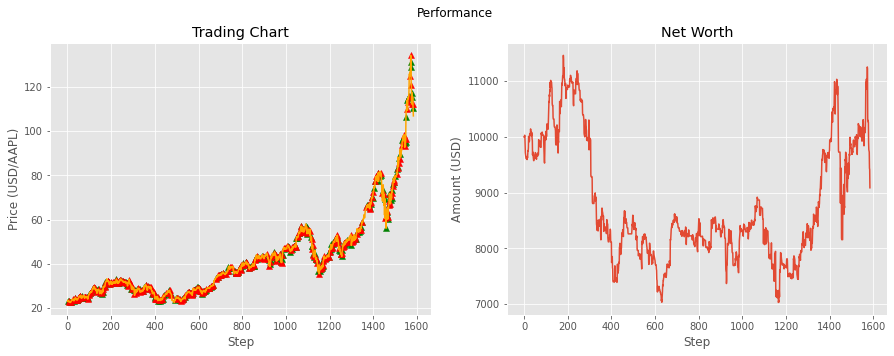

In [ ]:
env = create_env({
    "window_size": 25
})

episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

#**Evaluate**

In [ ]:
def create_eval_env(config: dict):
    #close price
    p = Stream.source(Ctestfeed, dtype="float").rename("USD-AAPL")
    #open price
    O = Stream.source(Otestfeed, dtype="float").rename("open")
    #volume
    V = Stream.source(Vtestfeed, dtype="float").rename("volume")
    #high
    H = Stream.source(Htestfeed, dtype="float").rename("high")
    #low
    L = Stream.source(Ltestfeed, dtype="float").rename("low")

    stockexchange = Exchange("Nasdaq", service=execute_order)(
        p
    )

    cash = Wallet(stockexchange, 10000 * USD)
    asset = Wallet(stockexchange, 0 * AAPL)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])

    feed = DataFeed([
        p,
        p.ewm(span=10).mean().rename("fast"),
        p.ewm(span=50).mean().rename("medium"),
        p.ewm(span=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr"),
        rsi(p, period=20).rename("rsi"),
        macd(p, fast=10, slow=50, signal=5).rename("macd"),
        O,
        H,
        L,
        V
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(Ctestfeed, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment

/usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return self.op(self.inputs[0].value, self.inputs[1].value)


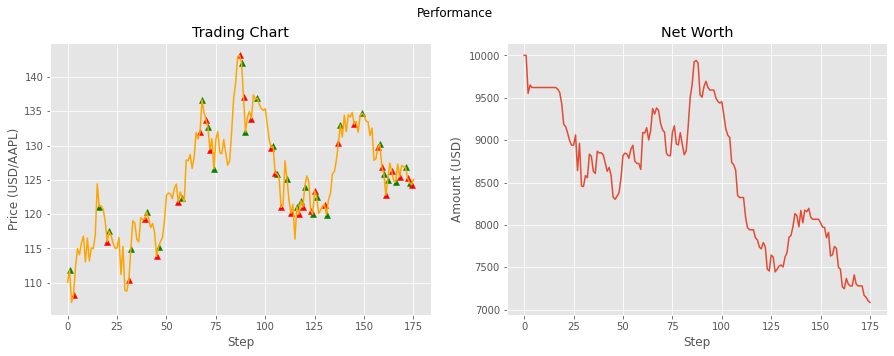

In [ ]:
env = create_eval_env({
    "window_size": 25
})

episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()